<a href="https://colab.research.google.com/github/yequalsmxplusc/project/blob/main/CHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymoo pyswarm openpyxl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=6239ff8eec1988ac390fa0be4e5859652aac16e76ab2d23e23073129b907191a
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=63401ccd6d1920f8bbd18f18a49e0c0c849ff332bd5408c841ad284dc047ec47
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Suc

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Load and preprocess data for aspect ratio 0.3
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

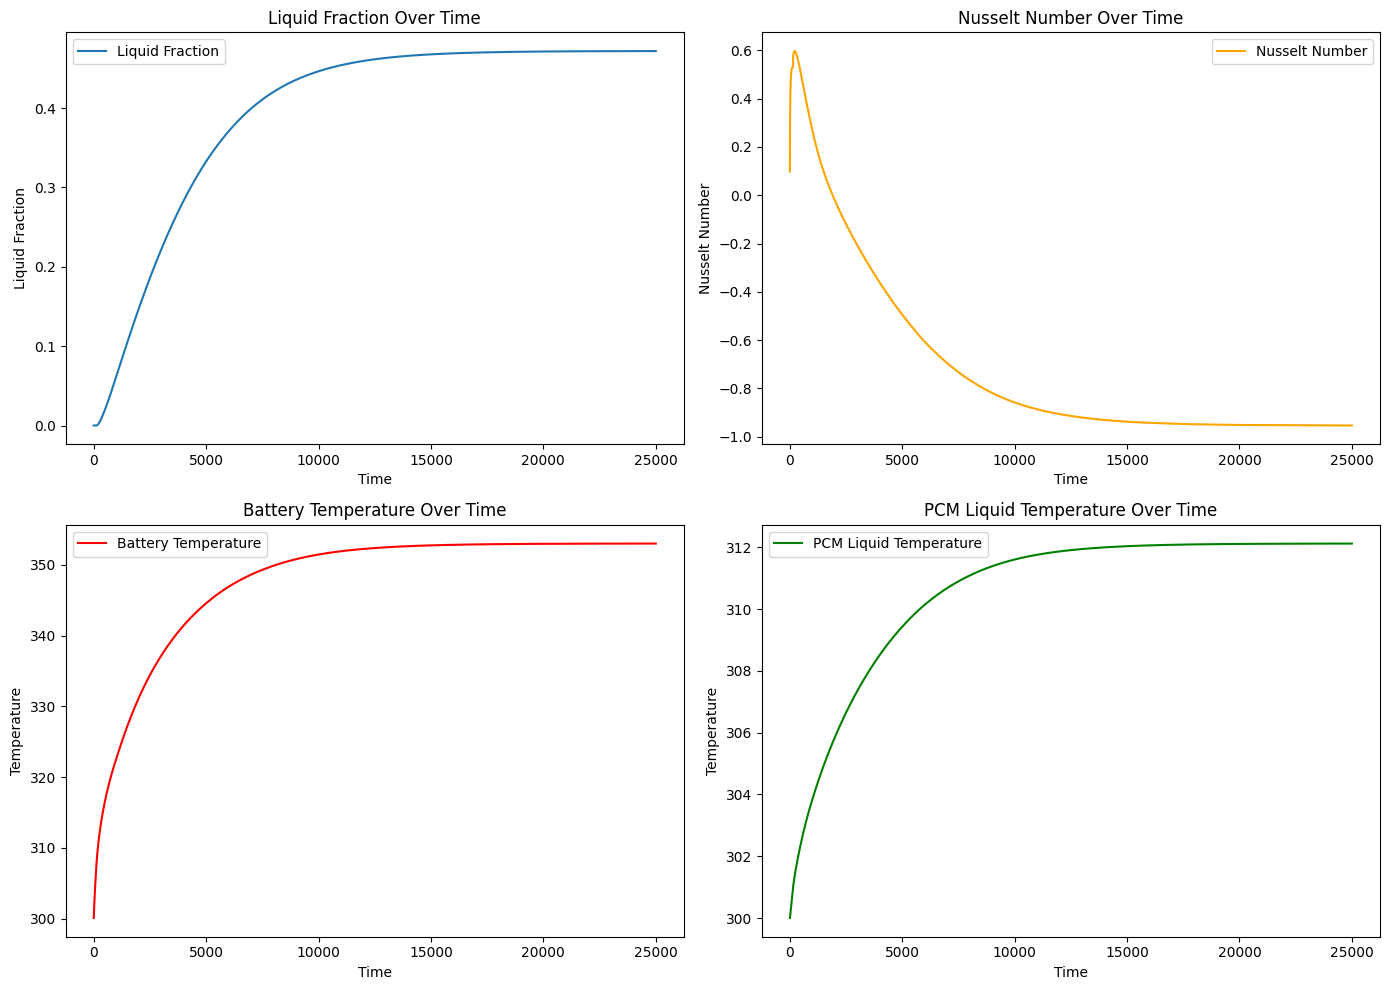

In [3]:
import matplotlib.pyplot as plt

# Load your data from an Excel file
df = pd.read_excel('/content/0.3.xlsx')  # Replace 'your_data_file.xlsx' with the path to your actual data file

# Sort data by time
df = df.sort_values('time')

# Plotting the data
plt.figure(figsize=(14, 10))

# Plot Liquid Fraction
plt.subplot(2, 2, 1)
plt.plot(df['time'], df['liquid_frac'], label='Liquid Fraction')
plt.xlabel('Time')
plt.ylabel('Liquid Fraction')
plt.title('Liquid Fraction Over Time')
plt.legend()

# Plot Nusselt Number
plt.subplot(2, 2, 2)
plt.plot(df['time'], df['Nu'], label='Nusselt Number', color='orange')
plt.xlabel('Time')
plt.ylabel('Nusselt Number')
plt.title('Nusselt Number Over Time')
plt.legend()

# Plot Battery Temperature
plt.subplot(2, 2, 3)
plt.plot(df['time'], df['T_battery'], label='Battery Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Battery Temperature Over Time')
plt.legend()

# Plot PCM Liquid Temperature
plt.subplot(2, 2, 4)
plt.plot(df['time'], df['T_pcm'], label='PCM Liquid Temperature', color='green')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('PCM Liquid Temperature Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Define the LSTM model
class SimplePINN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimplePINN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predict temperature

    def forward(self, x):
        # Ensure the input tensor has the correct shape
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension if it's missing
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

# Load and preprocess data
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Load and preprocess data
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

# Define the optimization problem
class BatteryCoolingProblem(Problem):
    def __init__(self, model, X_train, y_train):
        super().__init__(n_var=3, n_obj=2, n_constr=1, xl=np.array([0.1, 1000, 0.1]), xu=np.array([0.9, 2000, 0.9]))
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 3)
        liquid_frac, Nu, T_pcm = x[:, 0], x[:, 1], x[:, 2]

        temps = 50 - 15*0.3 + 0.5*np.sin(10*0.3) + 0.1*liquid_frac - 0.05*Nu + 0.01*T_pcm
        safety_margins = 5 + 20*0.3 - 2*np.cos(8*0.3) - 0.2*liquid_frac + 0.1*Nu - 0.05*T_pcm
        vortex_constraint = 0.3 - (0.35 + 0.05*np.sin(5*0.3)) + 0.01*liquid_frac - 0.005*Nu + 0.001*T_pcm

        out["F"] = np.column_stack([temps, -safety_margins])
        out["G"] = vortex_constraint

# Initialize the model
model = SimplePINN(input_size=4)

# Example usage of the optimization problem
problem = BatteryCoolingProblem(model, torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
algorithm = NSGA2(pop_size=30, n_offsprings=15, eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 50), seed=42, verbose=True)

# Define the objective function for PSO
def objective_function(x):
    return np.sum(x**2)  # Replace with your actual objective function

# Run PSO to get optimized parameters
lb = [0.1, 1000, 0.1]
ub = [0.9, 2000, 0.9]
x_opt, _ = pso(objective_function, lb, ub, swarmsize=20, maxiter=50)

# Example: Modify dataset based on optimization results
optimized_params = np.append(x_opt, 300.0)  # Assuming T_pcm is the fourth parameter
optimized_data = pd.DataFrame({
    'aspect_ratio': optimized_params[0],
    'liquid_frac': optimized_params[1],
    'Nu': optimized_params[2],
    'T_pcm': optimized_params[3],
    'T_battery': model(torch.tensor(optimized_params[:4], dtype=torch.float32).unsqueeze(0)).item()
}, index=[0])

# Save the optimized dataset
optimized_data.to_csv('optimized_data.csv', index=False)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       30 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       45 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |  0.000000E+00 |  2.3208224393 |         ideal
     4 |       75 |      1 |  0.000000E+00 |  0.000000E+00 |  0.3633220635 |         ideal
     5 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      105 |      1 |  0.000000E+00 |  0.000000E+00 |  0.7234067849 |         ideal
     7 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      135 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0525466186 |         ideal
     9 |      150 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      165 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0210259233 |         ideal

In [5]:
def load_data(data_path):
    """Load data file (CSV or Excel) without time-series processing"""
    if data_path.endswith('.csv'):
        return pd.read_csv(data_path, encoding='latin1')
    else:
        return pd.read_excel(data_path, engine='openpyxl')

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Handle both time-series and optimization result files"""
    data = load_data(data_path)

    # CASE 1: Time-series data (has 'time' column)
    if 'time' in data.columns:
        data = data.sort_values('time')
        if 'liquid_frac' in data.columns:
            data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
        data = data.dropna()

        # Train-test split
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # Create sequences
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
            target_col = ['T_battery']
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq[target_col].iloc[-1].values)
            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

    # CASE 2: Optimization results (single/multiple rows)
    else:
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']

        # Convert single row to sequence format
        if len(data) == 1:
            X_train = np.array([data[features].values] * seq_length).reshape(1, seq_length, -1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()
        else:
            X_train = np.stack([data[features].values] * seq_length, axis=1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()

    # Normalization
    def normalize(X_train, X_test, y_train, y_test):
        X_mean = X_train.mean(axis=(0, 1)) if X_train.ndim == 3 else X_train.mean()
        X_std = X_train.std(axis=(0, 1)) if X_train.ndim == 3 else X_train.std()
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)

        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)

        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Usage
try:
    # For time-series data
    X_train_04, X_test_04, y_train_04, y_test_04, _ = load_and_preprocess_data('/content/0.4.xlsx')

    # For optimization results
    X_train_opt, X_test_opt, y_train_opt, y_test_opt, _ = load_and_preprocess_data('/content/optimized_data.csv')

except Exception as e:
    print(f"Error: {str(e)}")

In [6]:
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Load and preprocess data with identical structure validation"""
    try:
        # Load data with strict validation
        data = pd.read_excel(data_path, engine='openpyxl')

        # Validate expected columns (modify this list to match your ACTUAL columns)
        expected_columns = [
            'time',              # Time index
            'aspect_ratio',      # Geometry parameter
            'liquid_frac',       # Phase change progress
            'Nu',                # Nusselt number
            'T_pcm',             # PCM temperature
            'T_battery'          # Battery temperature (target)
        ]

        # Verify all expected columns exist
        missing_cols = [col for col in expected_columns if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing critical columns in {data_path}: {missing_cols}")

        # Sort by time and preprocess
        data = data.sort_values('time')
        data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5, min_periods=1).mean()
        data = data.dropna()

        # Train-test split
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # Create sequences
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']  # Input features
            target_col = 'T_battery'                                   # Prediction target
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq[target_col].iloc[-1])
            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

        # Normalization
        def normalize(X_train, X_test, y_train, y_test):
            X_mean = X_train.mean(axis=(0, 1))
            X_std = X_train.std(axis=(0, 1))
            y_mean, y_std = y_train.mean(), y_train.std()

            X_train = (X_train - X_mean) / (X_std + 1e-8)
            X_test = (X_test - X_mean) / (X_std + 1e-8)
            y_train = (y_train - y_mean) / (y_std + 1e-8)
            y_test = (y_test - y_mean) / (y_std + 1e-8)

            return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

        return normalize(X_train, X_test, y_train, y_test)

    except Exception as e:
        print(f"ERROR in {data_path}: {str(e)}")
        print("Please verify:")
        print("1. File exists and is accessible")
        print("2. Contains all required columns:", expected_columns)
        print("3. No empty cells in critical columns")
        raise

# Example safe loading procedure
def safe_load_dataset(path, aspect_ratio):
    try:
        X_train, X_test, y_train, y_test, stats = load_and_preprocess_data(path)
        print(f"Successfully loaded {aspect_ratio} data")
        return X_train, X_test, y_train, y_test, stats
    except Exception as e:
        print(f"Failed to load {aspect_ratio} data")
        return None

# Load all datasets
datasets = {
    '0.4': safe_load_dataset('/content/0.4.xlsx', '0.4'),
    '0.5': safe_load_dataset('/content/0.5.xlsx', '0.5'),
    # Add more as needed
}

# Remove failed loads
datasets = {k: v for k, v in datasets.items() if v is not None}

Successfully loaded 0.4 data
Successfully loaded 0.5 data


In [7]:
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score,
                           mean_absolute_error,
                           mean_squared_error, r2_score,
                           confusion_matrix)
import seaborn as sns

def evaluate_model(model, X_test, y_test, norm_stats, aspect_ratio):
    """Evaluate model and return comprehensive metrics"""
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = y_test * y_std + y_mean
    y_pred_actual = y_pred * y_std + y_mean

    # Regression metrics
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    r2 = r2_score(y_test_actual, y_pred_actual)

    # Classification metrics (for overheating detection)
    temp_threshold = 45  # Adjust based on your requirements
    y_test_class = (y_test_actual > temp_threshold).astype(int)
    y_pred_class = (y_pred_actual > temp_threshold).astype(int)

    accuracy = accuracy_score(y_test_class, y_pred_class)
    precision = precision_score(y_test_class, y_pred_class, zero_division=0)
    recall = recall_score(y_test_class, y_pred_class, zero_division=0)
    f1 = f1_score(y_test_class, y_pred_class, zero_division=0)

    # Plotting
    plt.figure(figsize=(15, 5))
    # ... [rest of plotting code from previous example] ...

    return {
        'mae': mae, 'rmse': rmse, 'r2': r2,
        'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1
    }

In [8]:
results = {}
for aspect_ratio, (X_train, X_test, y_train, y_test, stats) in datasets.items():
    print(f"\n\033[1mEvaluating Aspect Ratio {aspect_ratio}\033[0m")
    results[aspect_ratio] = evaluate_model(model, X_test, y_test, stats, aspect_ratio)


Evaluating Aspect Ratio 0.4

Evaluating Aspect Ratio 0.5


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [9]:
print("\n\033[1mComparative Performance Across Aspect Ratios:\033[0m")
print("{:<10} {:<8} {:<8} {:<8} {:<10} {:<10} {:<10}".format(
    "Ratio", "MAE(°C)", "RMSE(°C)", "R²", "Accuracy", "Precision", "F1"))

for ratio, metrics in results.items():
    print("{:<10} {:<8.2f} {:<8.2f} {:<8.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(
        ratio, metrics['mae'], metrics['rmse'], metrics['r2'],
        metrics['accuracy'], metrics['precision'], metrics['f1']))


Comparative Performance Across Aspect Ratios:
Ratio      MAE(°C)  RMSE(°C) R²       Accuracy   Precision  F1        
0.4        30.70    30.70    -21303.04 1.00       1.00       1.00      
0.5        25.43    25.43    -148062.13 1.00       1.00       1.00      
